In [ ]:
import requests
import pandas as pd

def get_global_earthquakes(min_magnitude=3.5, limit=10000):
    """
    USGS API에서 실시간 지진 데이터를 가져옴
    """
    url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
    params = {
        "format": "geojson",
        "minmagnitude": min_magnitude,
        "limit": limit,
        "orderby": "time"
    }
    
    response = requests.get(url, params=params)
    if response.status_code != 200:
        print("⚠️ USGS API 요청 실패! 상태 코드:", response.status_code)
        return pd.DataFrame()  

    data = response.json()

    earthquakes = []
    for feature in data.get("features", []):
        properties = feature["properties"]
        geometry = feature["geometry"]
        earthquakes.append({
            "time": properties["time"],
            "magnitude": properties["mag"],
            "place": properties["place"],
            "lat": geometry["coordinates"][1],
            "lon": geometry["coordinates"][0],
            "depth": geometry["coordinates"][2]
        })

    return pd.DataFrame(earthquakes)

# ✅ USGS API에서 실시간 데이터 가져오기
df_global = get_global_earthquakes()
print(df_global.head())  # 데이터 확인


            time  magnitude                                         place  \
0  1740462533000        5.9  122 km NNE of Punta Cana, Dominican Republic   
1  1740461848168        5.3              212 km W of Port McNeill, Canada   
2  1740457512237        4.7         43 km NE of Ambunti, Papua New Guinea   
3  1740452880418        4.8           283 km SSW of Pagar Alam, Indonesia   
4  1740448175575        4.7                 south of the Kermadec Islands   

       lat       lon  depth  
0  19.6430  -68.0740    0.0  
1  50.4559 -130.0816   10.0  
2  -3.9198  143.0688   35.0  
3  -6.4138  102.3188   10.0  
4 -32.7588 -178.2075   10.0  


In [204]:
from sklearn.preprocessing import StandardScaler

# 1️⃣ KNN 학습을 위한 데이터 준비
df_global = df_global.dropna()  # 결측값 제거
X = df_global[['lat', 'lon', 'depth']]  # 위치 및 깊이 정보만 사용
y = (df_global['magnitude'] > 4.0).astype(int)  # 규모 4.0 이상이면 1 (지진 발생 가능)

# 2️⃣ 데이터 정규화 (KNN에서는 거리 기반 연산이므로 필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ 데이터 전처리 완료!")


✅ 데이터 전처리 완료!


In [205]:
from sklearn.neighbors import KNeighborsClassifier

# 1️⃣ KNN 모델 학습
knn = KNeighborsClassifier(n_neighbors=20,weights='distance')  # K값을 10으로 설정하여 예측 안정화
knn.fit(X_scaled, y)

print("✅ KNN 모델 학습 완료!")


✅ KNN 모델 학습 완료!


In [208]:
import numpy as np

def predict_earthquake(lat, lon, depth=10.0):
    """
    새로운 좌표의 지진 발생 확률을 KNN이 자동으로 예측
    """
    input_df = pd.DataFrame([[lat, lon, depth]], columns=['lat', 'lon', 'depth'])
    input_scaled = scaler.transform(input_df)
    prob = knn.predict_proba(input_scaled)[0]  # 지진 발생 확률 (0~1)
    return round(prob[1] * 100, 2) if len(prob) > 1 else round(prob[0] * 100, 2)

# ✅ 특정 지역(서울)에서 지진 발생 확률 예측
lat_test, lon_test = 37.5, 127.0  # 서울
test_prob = predict_earthquake(lat_test, lon_test)
print(f"📍 {lat_test}, {lon_test}의 지진 발생 확률: {test_prob}%")


📍 37.5, 127.0의 지진 발생 확률: 95.65%


In [209]:
# 데이터 크기 확인
print("✅ 훈련 데이터 개수:", df_global.shape[0])


✅ 훈련 데이터 개수: 1107


c:\Users\vhzkf\anaconda3\envs\hi\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vhzkf\anaconda3\envs\hi\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vhzkf\anaconda3\envs\hi\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vhzkf\anaconda3\envs\hi\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\vhzkf\anaconda3\envs\hi\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44508 (\N{HANGUL SYLLABLE GYU}) missing from font(s) DejaVu 

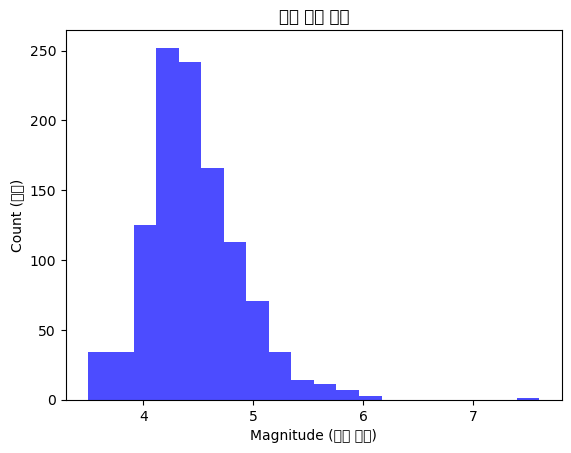

In [210]:
import matplotlib.pyplot as plt

plt.hist(df_global["magnitude"], bins=20, color="blue", alpha=0.7)
plt.xlabel("Magnitude (지진 규모)")
plt.ylabel("Count (개수)")
plt.title("지진 규모 분포")
plt.show()


In [211]:
# ✅ 지진 발생 여부(y) 데이터 비율 확인
print("✅ 지진 발생 여부 비율:")
print(df_global['magnitude'].apply(lambda x: 1 if x > 4.5 else 0).value_counts(normalize=True))


✅ 지진 발생 여부 비율:
magnitude
0    0.620596
1    0.379404
Name: proportion, dtype: float64


In [212]:
from sklearn.utils import resample

# ✅ 1. 규모 4.0~4.5 데이터와 4.5 이상 데이터를 분리
df_small_quakes = df_global[df_global['magnitude'] < 4.5]  # 작은 지진
df_large_quakes = df_global[df_global['magnitude'] >= 4.5]  # 큰 지진

# ✅ 2. 큰 지진(4.5 이상)의 샘플 수를 늘리기 (Oversampling)
if len(df_small_quakes) > 0:
    df_large_quakes_resampled = resample(df_large_quakes,
                                         replace=True,  # 복제 허용
                                         n_samples=len(df_small_quakes),  # 작은 지진과 개수 맞추기
                                         random_state=42)
else:
    df_large_quakes_resampled = df_large_quakes.copy()

# ✅ 3. Oversampling된 데이터 병합 (균형 맞추기)
df_balanced = pd.concat([df_small_quakes, df_large_quakes_resampled])

print("✅ 데이터 균형 조정 완료!")
print(df_balanced['magnitude'].describe())  # 규모 분포 확인


✅ 데이터 균형 조정 완료!
count    1152.000000
mean        4.489340
std         0.417051
min         3.500000
25%         4.200000
50%         4.480000
75%         4.700000
max         7.600000
Name: magnitude, dtype: float64


In [213]:
# ✅ 1. 새로운 학습 데이터 설정
X = df_balanced[['lat', 'lon', 'depth']]
y = (df_balanced['magnitude'] >= 4.5).astype(int)  # 4.5 이상이면 1, 아니면 0

# ✅ 2. 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ 3. KNN 학습 (K값 증가)
knn = KNeighborsClassifier(n_neighbors=500)  # 기존 30 → 50으로 증가
knn.fit(X_scaled, y)

print("✅ 새로운 KNN 모델 학습 완료!")


✅ 새로운 KNN 모델 학습 완료!


In [214]:
test_prob = predict_earthquake(37.5, 127.0)
print(f"📍 37.5, 127.0의 지진 발생 확률 (개선 후): {test_prob}%")


📍 37.5, 127.0의 지진 발생 확률 (개선 후): 41.6%


In [215]:
from sklearn.ensemble import RandomForestClassifier

# ✅ Random Forest 모델 학습
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

def predict_earthquake_rf(lat, lon, depth=10.0):
    input_df = pd.DataFrame([[lat, lon, depth]], columns=['lat', 'lon', 'depth'])
    input_scaled = scaler.transform(input_df)
    prob = rf.predict_proba(input_scaled)[0][1]  # 지진 발생 확률 (0~1)
    return round(prob * 100, 2)

# ✅ Random Forest로 서울(37.5, 127.0) 예측
test_prob_rf = predict_earthquake_rf(37.5, 127.0)
print(f"📍 37.5, 127.0의 지진 발생 확률 (Random Forest): {test_prob_rf}%")


📍 37.5, 127.0의 지진 발생 확률 (Random Forest): 38.0%


In [217]:
import joblib

# ✅ 1. 모델 저장 (Random Forest)
joblib.dump(rf, "earthquake_model.joblib")

# ✅ 2. 스케일러 저장 (데이터 정규화를 위해 필요)
joblib.dump(scaler, "scaler.joblib")

print("✅ 모델과 스케일러 저장 완료 (joblib 사용)")


✅ 모델과 스케일러 저장 완료 (joblib 사용)
